# Detección de Fraude con modelos de Machine Learning
En este documento se muestra cómo hacer predicciones de fraude con modelos de Machine Learning en Python. Se utiliza la base de datos sintéticos, generados por PaySim mobile, que e puede descargar del sitio web de Kaggle:

https://www.kaggle.com/ntnu-testimon/paysim1

Esta base de datos se ha utilizado en numerosos estudios similares al que se presenta en este documento, entre los cuales destaca el paper citado a cotniuación:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

## Variables

La base de datos cuenta con las siguientes variables:

**step** - unidades de tiempo. En total se tienen 744 steps, que corresponde a una simulación de 30 días.
maps

**type** - tipo de transacción: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER.

**amount** - monto de la transacción en moneda local.

**nameOrig** - identificación del cliente que originó la transacción.

**oldbalanceOrg** - saldo inicial del cliente, antes de la transacción.

**newbalanceOrig** - saldo final del cliente, después de la transacción.

**nameDest** - identificación del cliente receptor de la transacción.

**oldbalanceDest** - saldo inicial del receptor antes de la transacción. 

**newbalanceDest** - saldo final del receptor después de la transacción.

**isFraud** - transacciones fraudulentas. Los agentes buscan tomar control de las cuentas de los clientes, vaciar sus fondos transfiriéndolos a otra cuenta, y luego retirar los fondos del sistema.

**isFlaggedFraud** - indicador de posible fraude generado por la institución financiera. Un posible fraude se define como una transacción en la que se intenta transferir un monto mayor a $200.000 en una sola transacción.

Para empezar con el análisis se cargan los paquetes a utilizar y se ajustan algunos formatos:



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '%.4f' % x) # formato del output, 4 decimales
pd.set_option('display.max_columns', 100) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 100) # número máximo de filas a mostrar en el terminal

## Análisis exploratorio de la base de datos

En primer lugar se cargan los datos y se asignan a un dataframe. Luego se busca la siguiente información:

- La base de datos tiene un total de 6.362.620 observaciones (ejemplos) y 11 variables.
- Algunas variables contienen números enteros (step, isFraud, isFlaggedFraud), otras contienen floating numbers (variables relacionadas con los montos de las transacciones) y otras variables son categóricas (tipo de transacción, nombre del origen y destino).
- La gran mayoría de las observaciones son no fraudulentas, un 99,87%, mientras que sólo el 0,13% consiste en transacciones fraudulentas.

In [3]:
dataset = pd.read_csv('dataset.csv')
print(dataset.shape)
print(dataset.info())
print(dataset['isFraud'].value_counts())
print(dataset['isFraud'].value_counts(normalize=True))

(6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
0    6354407
1       8213
Name: isFraud, dtype: int64
0   0.9987
1   0.0013
Name: isFraud, dtype: float64


A continuación se crea un conjunto de variables dummy que señalan cuando una de las variables relacionadas con las transacciones es igual a cero. Esto se hace debido a que hay una gran cantidad de observaciones con ceros, incluso se da que los saldos iniciales y finales del origen o destino son ceros, lo que es sospechoso.

Luego se construye una tabla para analizar el porcentaje de casos en que se encontró esta situación, según cáracter de la transacción: legal o ilegal (fraudulenta). Se observa que, para la  mayoría de las variables, los ceros son más frecuentes en las transacciones ilegales, por lo que se podrían considerar útiles para identificar este tipo de transacciones.

In [4]:
contV = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
dataset[contV].describe()

for e in contV:
    dataset[e + 'D'] = dataset[e].apply(lambda val: 1 if val == 0 else 0)

contVD = ['amountD', 'oldbalanceOrgD', 'newbalanceOrigD', 'oldbalanceDestD', 'newbalanceDestD']

table1 = dataset.pivot_table(index='isFraud',
                            values=contVD,
                            aggfunc='mean')
print(table1)

amountD  newbalanceDestD  newbalanceOrigD  oldbalanceDestD  \
isFraud                                                               
0         0.0000           0.3833           0.5668           0.4248   
1         0.0019           0.4981           0.9805           0.6515   

         oldbalanceOrgD  
isFraud                  
0                0.3309  
1                0.0050  


A continuación se crean dos nuevas variables de interés. Una dummy para cuando en el origen el saldo inicial y final es cero, y para cuando en el destino el saldo inicial y final es cero. Se observa que para el caso del destino esta situación es un indicio de caso fraudulento, mientras que en el caso del origen, esta variable es más frecuente en el caso de transacciones legales.

In [5]:
dataset['zeroOrig'] = dataset['oldbalanceOrgD'] * dataset['newbalanceOrigD']
dataset['zeroDest'] = dataset['oldbalanceDestD'] * dataset['newbalanceDestD']

table2 = dataset.pivot_table(index='isFraud',
                            values=['zeroOrig', 'zeroDest'],
                            aggfunc='mean')
print(table2)


zeroDest  zeroOrig
isFraud                    
0          0.3640    0.3287
1          0.4963    0.0050


Por último, se construye una tabla que muestre el porcentaje de transacciones fraudulentas según tipo de transacción. Se observa que las transacciones fraudulentas se dan principalmente en los tipos: CASH_OUT y TRANSFER.

In [6]:
table3 = dataset.pivot_table(index='type',
                             values='isFraud',
                             aggfunc='mean')
print(table3)

isFraud
type             
CASH_IN    0.0000
CASH_OUT   0.0018
DEBIT      0.0000
PAYMENT    0.0000
TRANSFER   0.0077


## Toma de una muestra de la base de datos
Dado que la mayoría de las transacciones son no fraudulentas, se tiene una base de datos desbalanceada, lo que puede provocar problemas en los modelos predictivos. Por lo tanto, se optó por mantener las 8.213 observaciones fraudulentas, y tomar una muestra aleatoria de 8.213 observaciones no fraudulentas. Luego, mediante la unión de estos dos subconjuntos de datos se obtiene una base de datos balanceada, que es la ideal para hacer las estimaciones. Adicionalmente, se utiliza un subconjunto de variables de la base de datos. Se omiten las identificaciones del origen y destino, y la variable isFlaggedFrau, y se consideranlas dummies para ceros en el saldo inifial y final en el destino y origen de la transacción.

De esta manera, se obtiene una base de datos de 16.426 observaciones y 10 variables, perfectamente balanceada 50%/50% entre transacciones legales e ilegales.

In [7]:
datasubset = dataset[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                      'oldbalanceDest', 'newbalanceDest', 'isFraud', 'zeroOrig', 'zeroDest']]
FraudSample = datasubset[datasubset['isFraud']==1]
noFraudSample = datasubset[datasubset['isFraud']==0].sample(n=FraudSample.shape[0], random_state=123)
data = pd.concat([FraudSample, noFraudSample]).reset_index(drop=True)
print(data.shape)
print(data['isFraud'].value_counts())
print(data['isFraud'].value_counts(normalize=True))

(16426, 10)
1    8213
0    8213
Name: isFraud, dtype: int64
1   0.5000
0   0.5000
Name: isFraud, dtype: float64


## Preprocesamiento de los datos

A continuación se hace un preprocesamiento de los datos, en que los datos se preparan para ser utilizados en los modelos de machine learning.

Primero se generan variables dummies para el tipo de transacción. Luego las dummies se unen a la base de datos, y se elimina una de las dummies, que no es necesaria. Asimismo, se elimina la variable categórica original.

In [10]:
# Dummies para el tipo de transacción
dataset['zeroOrig'] = dataset['oldbalanceOrgD'] * dataset['newbalanceOrigD']
dataset['zeroDest'] = dataset['oldbalanceDestD'] * dataset['newbalanceDestD']

table2 = dataset.pivot_table(index='isFraud',
                            values=['zeroOrig', 'zeroDest'],
                            aggfunc='mean')
print(table2)

typeD = pd.get_dummies(data['type'])
data = pd.concat([data, typeD], axis=1)
data = data.drop(['type', 'CASH_IN'], axis=1)
print(data.head())

zeroDest  zeroOrig
isFraud                    
0          0.3640    0.3287
1          0.4963    0.0050
   step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   181.0000       181.0000          0.0000          0.0000   
1     1   181.0000       181.0000          0.0000      21182.0000   
2     1  2806.0000      2806.0000          0.0000          0.0000   
3     1  2806.0000      2806.0000          0.0000      26202.0000   
4     1 20128.0000     20128.0000          0.0000          0.0000   

   newbalanceDest  isFraud  zeroOrig  zeroDest  CASH_OUT  DEBIT  PAYMENT  \
0          0.0000        1         0         1         0      0        0   
1          0.0000        1         0         0         1      0        0   
2          0.0000        1         0         1         0      0        0   
3          0.0000        1         0         0         1      0        0   
4          0.0000        1         0         1         0      0        0   

   TRANSFER  
0         1

Luego se generan dos conjuntos de datos, uno para entrenar los modelos (train set) y otro para testear su capacidad predictiva (test set).

In [11]:
# Generación de bases de datos de entrenamiento y testeo
y = data['isFraud']
X = data.drop('isFraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

Luego se estandarizan las variables continuas, mientras que las variables dummy se dejan intactas. Esto es necesario para mejorar el ajuste de los modelos de Logistic Regression y Support Vector Machines. De esta manera todas las variables continuas quedan con media 0 y desviación estándar igual a 1.

In [12]:
# Estandarización de variables
contV = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = StandardScaler()
X_train[contV] = scaler.fit_transform(X_train[contV])
print(X_train.describe())

X_test[contV] = scaler.transform(X_test[contV])

step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count 13140.0000 13140.0000     13140.0000      13140.0000      13140.0000   
mean      0.0000    -0.0000         0.0000         -0.0000          0.0000   
std       1.0000     1.0000         1.0000          1.0000          1.0000   
min      -1.5692    -0.4427        -0.3749         -0.2074         -0.2381   
25%      -0.7479    -0.4230        -0.3719         -0.2074         -0.2381   
50%      -0.1267    -0.3496        -0.3387         -0.2074         -0.2381   
75%       0.5304    -0.1498        -0.1319         -0.2074         -0.0906   
max       2.2399     7.0771        17.5430         18.9509         67.8699   

       newbalanceDest   zeroOrig   zeroDest   CASH_OUT      DEBIT    PAYMENT  \
count      13140.0000 13140.0000 13140.0000 13140.0000 13140.0000 13140.0000   
mean           0.0000     0.1708     0.4318     0.4244     0.0023     0.1707   
std            1.0000     0.3763     0.4953     0.4943     0.0477    

## Modelamiento
En esta sección se modelan los datos y se hacen predicciones en base a un conjunto de modelos de machine learning:

- **Logistic Regression**. Variante particular del modelo lineal generalizado.

- **Support Vector Machines**. Se caracteriza por poner énfasis en una serie de puntos que se conocen como support vectors, que se ubican donde se produce el límite entre ambas categorías (Fraude/No Fraude).

- **Decision Tree**. Árbol de decisión.

- **Random Forest**. Modelo de ensemble learning (Bagging), que combina las predicciones de múltiples árboles de decisión.

- **AdaBoost**. Modelo de ensemble learning (Adaptive Boosting), que combina las predicciones de múltiples árboles de decisión sencillos. En cada nueva iteración se le da un mayor peso a las observaciones mal clasificadas por el árbol anterior.

- **XGBoost**. Modelo de ensemble learning (Gradient Boosting), que combina las predicciones de múltiples árboles de decisión sencillos. En cada nueva iteración el nuevo árbol se ajusta a los residuos del árbol anterior.

Para cada modelo se hizo un tuning de hiperparámetros usando la herramienta GridSearchCV de Scikit-learn. 

Para evaluar el desempeño de los modelos se utilizaron los siguientes indicadores:

- **Accuracy**: medida que muestra la suma de predicciones correctas (verdaderos y falsos positivos) sobre el total de predicciones.

- **ROC AUC**: área bajo la curva de ROC, es igual a la probabilidad de que un modelo clasificador asigne un valor mayor a una observación positiva seleccionada aleatoriamente, que a una observación negativa seleccionada aleatoriamente. En otras palabras, mientras mayor es el área (más cercana a 1) mayor es la tasa de verdaderos positivos, y menor es la tasa de falsos positivos.

- **F1 Score**: media harmónica de dos indicadores: Precision y Recall. Precision es el porcentaje de las observaciones clasificadas como positivas por el modelo (TP + FP), que son efectivamente positivas (TP). Recall (Sensitivity) es el porcentaje de las observaciones efectivamente positivas (TP + FN) que fueron clasificadas como positivas por el modelo (TP).

## Logistic Regression

In [14]:
# Logistic Regression
lr = LogisticRegression(max_iter=300, random_state=132)
# print(lr.get_params())
# l1: Lasso, l2: Ridge
parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25, 30], 
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_lr = searcher.best_estimator_
y_pred = best_lr.predict(X_test)
y_pred_proba = best_lr.predict_proba(X_test)[:,1]

Accuracy1 = searcher.score(X_test, y_test)
ROC_AUC1 = roc_auc_score(y_test, y_pred_proba)
F1Score1 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy1)
print("Area Under the ROC Curve:", ROC_AUC1)
print("F1 Score:", F1Score1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    3.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.4s finished
Best CV params {'C': 30, 'penalty': 'l2'}
Test accuracy of best CV params: 0.956177723676202
Area Under the ROC Curve: 0.9935197886679837
F1 Score: 0.9566003616636527


## Support Vector Classifier

In [15]:
# Support Vector Classifier
svm = SVC(random_state=123)
# print(svm.get_params())
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

svm = SVC(C=10, gamma=0.1, probability=True, random_state=123)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)[:,1]

Accuracy2 = svm.score(X_test, y_test)
ROC_AUC2 = roc_auc_score(y_test, y_pred_proba)
F1Score2 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy2)
print("Area Under the ROC Curve:", ROC_AUC2)
print("F1 Score:", F1Score2)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.4min finished
Best CV params {'C': 10, 'gamma': 0.1}
Test accuracy of best CV params: 0.9613511868533171
Area Under the ROC Curve: 0.9947066975519819
F1 Score: 0.9618274721971747


## Decision Tree Classifier

In [16]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=123)
# print(dt.get_params())
parameters = {'max_depth': [2, 3, 4],'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]}
searcher = GridSearchCV(dt, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_dt = searcher.best_estimator_
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:,1]

Accuracy3 = searcher.score(X_test, y_test)
ROC_AUC3 = roc_auc_score(y_test, y_pred_proba)
F1Score3 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy3)
print("Area Under the ROC Curve:", ROC_AUC3)
print("F1 Score:", F1Score3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
Best CV params {'max_depth': 2, 'min_samples_leaf': 0.12}
Test accuracy of best CV params: 0.9056603773584906
Area Under the ROC Curve: 0.9446307376060818
F1 Score: 0.9
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished


## Random Forest Classifier
Se incluye un gráfico en que se muestra la importancia de los predictores.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.6s finished
Best CV params {'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 350}


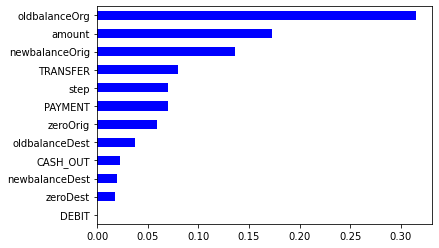

Test accuracy of best CV params: 0.9330493000608643
Area Under the ROC Curve: 0.9802107763473212
F1 Score: 0.9324739103744629


In [17]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=123)
# print(rf.get_params())
parameters = {'n_estimators': [100, 350, 500], 'max_features': ['log2', 'sqrt'],
              'min_samples_leaf': [0.10, 0.15, 0.20]}
searcher = GridSearchCV(rf, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_rf = searcher.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:,1]

importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

Accuracy4 = searcher.score(X_test, y_test)
ROC_AUC4 = roc_auc_score(y_test, y_pred_proba)
F1Score4 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy4)
print("Area Under the ROC Curve:", ROC_AUC4)
print("F1 Score:", F1Score4)

## AdaBoost Classifier

In [18]:
# AdaBoost Classifier
dt = DecisionTreeClassifier(random_state=123)
ada = AdaBoostClassifier(base_estimator=dt)
# print(ada.get_params())
parameters = {'n_estimators': [100, 350, 500], 'base_estimator__max_depth': [2, 3, 4],
              'base_estimator__min_samples_leaf': [0.10, 0.15, 0.20]}
searcher = GridSearchCV(ada, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_ada = searcher.best_estimator_
y_pred = best_ada.predict(X_test)
y_pred_proba = best_ada.predict_proba(X_test)[:,1]

Accuracy5 = searcher.score(X_test, y_test)
ROC_AUC5 = roc_auc_score(y_test, y_pred_proba)
F1Score5 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy5)
print("Area Under the ROC Curve:", ROC_AUC5)
print("F1 Score:", F1Score5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.1min finished
Best CV params {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 0.1, 'n_estimators': 500}
Test accuracy of best CV params: 0.9954351795496044
Area Under the ROC Curve: 0.9991027798635944
F1 Score: 0.9954448830853324


## XGBoost Classifier

In [19]:
# XGBoost Classifier
xgcl = xgb.XGBClassifier(seed=123)
# print(xgcl.get_params())
parameters = {'colsample_bytree': [0.3, 0.5, 0.7],
              'n_estimators': [100, 350, 500],
              'max_depth': [2, 3, 4]}
searcher = GridSearchCV(xgcl, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_xgcl = searcher.best_estimator_
y_pred = best_xgcl.predict(X_test)
y_pred_proba = best_xgcl.predict_proba(X_test)[:,1]

Accuracy6 = searcher.score(X_test, y_test)
ROC_AUC6 = roc_auc_score(y_test, y_pred_proba)
F1Score6 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy6)
print("Area Under the ROC Curve:", ROC_AUC6)
print("F1 Score:", F1Score6)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   33.6s finished
Best CV params {'colsample_bytree': 0.7, 'max_depth': 4, 'n_estimators': 350}
Test accuracy of best CV params: 0.995739500912964
Area Under the ROC Curve: 0.9994869323332279
F1 Score: 0.9957498482088646


## Evaluación final
En esta sección final se compara el desempeño de los distintos modelos. Se observa que, en general, todos los modelos tuvieron un excelente desempeño. El modelo más débil fue el Decision Tree, mientras que el mejor modelo fue **XGBoost**, que obtuvo los mejores indicadores en Accuracy y F1Score. Además, destaca **AdaBoost**, que obtuvo el mejor desempeño en ROC AUC.

In [21]:
Classifier = ['LR', 'SVM', 'DTree', 'RForest', 'AdaBoost', 'XGBoost']
Accuracy = [Accuracy1, Accuracy2, Accuracy3, Accuracy4, Accuracy5, Accuracy6]
ROC_AUC = [ROC_AUC1, ROC_AUC2, ROC_AUC3, ROC_AUC4, ROC_AUC5, ROC_AUC6]
F1Score = [F1Score1, F1Score2, F1Score3, F1Score4, F1Score5, F1Score6]
Resultados = pd.DataFrame({'Accuracy':Accuracy, 'ROC AUC':ROC_AUC, 'F1Score':F1Score}, index=Classifier)
print(Resultados.idxmax())
Resultados

Accuracy    XGBoost
ROC AUC     XGBoost
F1Score     XGBoost
dtype: object


,Accuracy,ROC AUC,F1Score
LR,0.9562,0.9935,0.9566
SVM,0.9614,0.9947,0.9618
DTree,0.9057,0.9446,0.9000
RForest,0.9330,0.9802,0.9325
AdaBoost,0.9954,0.9991,0.9954
XGBoost,0.9957,0.9995,0.9957
